In [ ]:
! pip install ogb torch torch-geometric
! pip install "numpy<2" --force-reinstall
! pip install torch==2.4 pandas scikit-learn pyvis
! pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/
! pip install torchdata==0.6.1 --force-reinstall


In [ ]:
import dgl
from dgl.data import CoauthorCSDataset
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

dgl_dataset = CoauthorCSDataset()
g = dgl_dataset[0]

feat = g.ndata['feat']
label = g.ndata['label']

src, dst = g.edges()
edge_index = torch.stack([src, dst], dim=0)

data = Data(
    x=feat,
    edge_index=edge_index,
    y=label
)

idx = torch.arange(data.num_nodes)
train_idx, temp_idx = train_test_split(idx, train_size=0.6, stratify=label, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=label[temp_idx], random_state=42)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[val_idx] = True
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = True


In [ ]:
import random
import numpy as np
def set_seed(seed: int = 42, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(42)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score


In [ ]:
def train_and_validate(model, data, optimizer, criterion, epochs=50, device='cpu'):
    """
    Trains `model` on `data.train_mask` and evaluates on `data.val_mask` each epoch.
    Reports the epoch with the best validation accuracy at the end and returns the best validation accuracy.

    Args:
        model       : a torch.nn.Module (e.g., GraphSAGE)
        data        : a torch_geometric.data.Data with x, edge_index, y, and train/val/test masks
        optimizer   : torch optimizer, e.g., torch.optim.Adam(model.parameters(), lr=0.01)
        criterion   : loss, e.g., torch.nn.CrossEntropyLoss()
        epochs      : number of training epochs
        device      : 'cpu' or 'cuda'
    """
    set_seed(42)
    model.to(device)
    data = data.to(device)

    best_val_acc = 0.0
    best_epoch   = 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask].view(-1))
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(data.x, data.edge_index)
            pred   = logits.argmax(dim=1)

            train_acc = accuracy_score(
                data.y[data.train_mask].cpu().numpy().ravel(),
                pred[data.train_mask].cpu().numpy()
            )
            val_acc = accuracy_score(
                data.y[data.val_mask].cpu().numpy().ravel(),
                pred[data.val_mask].cpu().numpy()
            )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch   = epoch

       # print(f"Epoch {epoch:03d} | "
              #f"Loss: {loss.item():.4f} | "
              #f"Train Acc: {train_acc:.4f} | "
              #f"Val Acc: {val_acc:.4f}")

    print(f"\nBest validation accuracy of {best_val_acc:.4f} "
          f"achieved at epoch {best_epoch}.\n")

    return best_val_acc


In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.layers.append(SAGEConv(hidden_channels, hidden_channels))
        self.linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.layers):
            x = conv(x, edge_index)
            if i != len(self.layers) - 1:
                x = F.relu(x)

        x = self.linear(x)
        return x


Cross validation on hidden size and layer counts

In [ ]:
hidden_sizes = [16,32, 64, 128, 256]
layer_counts = [1,2, 3]

best_config = None
best_val_acc = 0.0

for hidden in hidden_sizes:
    for layers in layer_counts:
        print(f"\nTraining model with hidden={hidden}, layers={layers}")

        model = GraphSAGE(
            in_channels=data.num_node_features,
            hidden_channels=hidden,
            out_channels=len(torch.unique(data.y)),
            num_layers=layers
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        val_acc = train_and_validate(model, data, optimizer, criterion, epochs=200, device='cuda')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = (hidden, layers)

        print(f"Best validation accuracy for hidden={hidden}, layers={layers}: {val_acc:.4f}")

print(f"\nOverall best configuration: Hidden={best_config[0]}, Layers={best_config[1]}")
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training model with hidden=16, layers=1

Best validation accuracy of 0.9509 achieved at epoch 183.

Best validation accuracy for hidden=16, layers=1: 0.9509

Training model with hidden=16, layers=2

Best validation accuracy of 0.9425 achieved at epoch 194.

Best validation accuracy for hidden=16, layers=2: 0.9425

Training model with hidden=16, layers=3

Best validation accuracy of 0.9356 achieved at epoch 155.

Best validation accuracy for hidden=16, layers=3: 0.9356

Training model with hidden=32, layers=1

Best validation accuracy of 0.9479 achieved at epoch 130.

Best validation accuracy for hidden=32, layers=1: 0.9479

Training model with hidden=32, layers=2

Best validation accuracy of 0.9457 achieved at epoch 168.

Best validation accuracy for hidden=32, layers=2: 0.9457

Training model with hidden=32, layers=3

Best validation accuracy of 0.9397 achieved at epoch 197.

Best validation accuracy for hidden=32, layers=3: 0.9397

Training model with hidden=64, layers=1

Best valid

Cross validation on aggregator

In [ ]:
class GraphSAGE_aggr(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, aggr='mean'):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.layers.append(SAGEConv(hidden_channels, hidden_channels))
        self.linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.layers):
            x = conv(x, edge_index)
            if i != len(self.layers) - 1:
                x = F.relu(x)

        x = self.linear(x)
        return x


In [ ]:
aggregators = ['mean', 'sum', 'max', 'lstm']

best_aggr = None
best_val_acc = 0.0

for aggr in aggregators:
    print(f"\nTraining model with aggregator = '{aggr}'")

    model = GraphSAGE_aggr(
        in_channels=data.num_node_features,
        hidden_channels=64,
        out_channels=len(torch.unique(data.y)),
        num_layers=1,
        aggr=aggr
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    val_acc = train_and_validate(model, data, optimizer, criterion, epochs=200, device='cuda')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_aggr = aggr

    print(f"Validation accuracy with aggr='{aggr}': {val_acc:.4f}")

print(f"\nBest aggregator: '{best_aggr}'")
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training model with aggregator = 'mean'

Best validation accuracy of 0.9534 achieved at epoch 144.

Validation accuracy with aggr='mean': 0.9534

Training model with aggregator = 'sum'

Best validation accuracy of 0.9534 achieved at epoch 144.

Validation accuracy with aggr='sum': 0.9534

Training model with aggregator = 'max'

Best validation accuracy of 0.9534 achieved at epoch 144.

Validation accuracy with aggr='max': 0.9534

Training model with aggregator = 'lstm'

Best validation accuracy of 0.9534 achieved at epoch 144.

Validation accuracy with aggr='lstm': 0.9534

Best aggregator: 'mean'
Best validation accuracy: 0.9534


Graph attention network

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, heads=8):
        super(GAT, self).__init__()
        self.layers = torch.nn.ModuleList()

        self.layers.append(GATConv(in_channels, hidden_channels, heads=heads))

        for _ in range(num_layers - 2):
            self.layers.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))

        self.layers.append(GATConv(hidden_channels * heads, out_channels, heads=1, concat=False))


    def forward(self, x, edge_index):
        for i, conv in enumerate(self.layers):
            x = conv(x, edge_index)
            if i != len(self.layers) - 1:
                x = F.elu(x)
        return x


In [ ]:
hidden_sizes = [16,32, 64, 128, 256]
layer_counts = [1,2, 3]
num_heads_list = [1,2, 4, 8,16]

best_config = None
best_val_acc = 0.0

for hidden in hidden_sizes:
    for layers in layer_counts:
        for heads in num_heads_list:
            print(f"\nTraining GAT model with hidden={hidden}, layers={layers}, heads={heads}")

            model = GAT(
                in_channels=data.num_node_features,
                hidden_channels=hidden,
                out_channels=len(torch.unique(data.y)),
                num_layers=layers,
                heads=heads
            )

            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = torch.nn.CrossEntropyLoss()

            val_acc = train_and_validate(model, data, optimizer, criterion, epochs=500, device='cuda')

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_config = (hidden, layers, heads)

            print(f"Validation acc for hidden={hidden}, layers={layers}, heads={heads}: {val_acc:.4f}")

print(f"\nBest configuration: Hidden={best_config[0]}, Layers={best_config[1]}, Heads={best_config[2]}")
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training GAT model with hidden=16, layers=1, heads=1

Best validation accuracy of 0.9095 achieved at epoch 213.

Validation acc for hidden=16, layers=1, heads=1: 0.9095

Training GAT model with hidden=16, layers=1, heads=2

Best validation accuracy of 0.9065 achieved at epoch 97.

Validation acc for hidden=16, layers=1, heads=2: 0.9065

Training GAT model with hidden=16, layers=1, heads=4

Best validation accuracy of 0.9187 achieved at epoch 60.

Validation acc for hidden=16, layers=1, heads=4: 0.9187

Training GAT model with hidden=16, layers=1, heads=8

Best validation accuracy of 0.9302 achieved at epoch 84.

Validation acc for hidden=16, layers=1, heads=8: 0.9302

Training GAT model with hidden=16, layers=1, heads=16

Best validation accuracy of 0.9326 achieved at epoch 46.

Validation acc for hidden=16, layers=1, heads=16: 0.9326

Training GAT model with hidden=16, layers=2, heads=1

Best validation accuracy of 0.9092 achieved at epoch 211.

Validation acc for hidden=16, layers=2

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.78 GiB (GPU 0; 14.74 GiB total capacity; 10.68 GiB already allocated; 232.12 MiB free; 14.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

The test accuracy is 0.9460


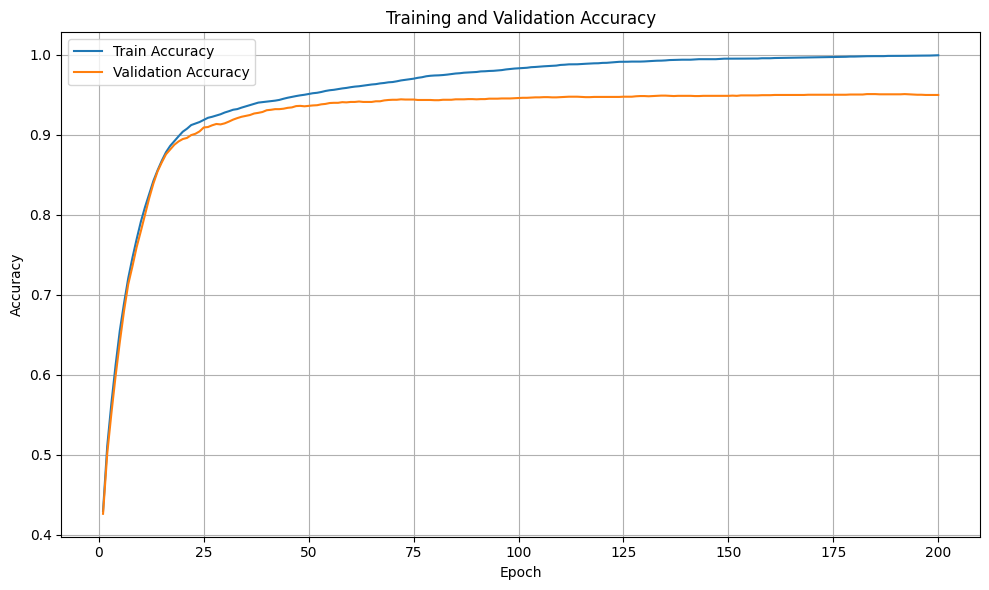

In [ ]:
model = GraphSAGE(
            in_channels=data.num_node_features,
            hidden_channels=64,
            out_channels=len(torch.unique(data.y)),
            num_layers=1
        )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

device =
set_seed(42)
model.to(device)
data = data.to(device)

for epoch in range(1, 200 + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].view(-1))
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
  logits = model(data.x, data.edge_index)
  pred   = logits.argmax(dim=1)
  test_acc = accuracy_score(
                data.y[data.test_mask].cpu().numpy().ravel(),
                pred[data.test_mask].cpu().numpy()
            )
print(f'The test accuracy is {test_acc}')